In [1]:
from keras import layers
from keras import models
import tensorflow as tf
import efficientnet.keras as efn

Using TensorFlow backend.


In [2]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.4
session = tf.Session(config=config)

In [3]:
# efficientnet-B0 모델 사용
conv_base = efn.EfficientNetB0(include_top=False, input_shape=(224, 224, 3))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [4]:
# 한국, 호주, 프랑스, 이탈리아, 미국 5개의 클래스로 분류
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(5, activation='softmax'))

In [5]:
conv_base.summary()

Model: "efficientnet-b0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 32) 0           stem_bn[0][0]                    
____________________________________________________________________________________

__________________________________________________________________________________________________
top_conv (Conv2D)               (None, 7, 7, 1280)   409600      block7a_project_bn[0][0]         
__________________________________________________________________________________________________
top_bn (BatchNormalization)     (None, 7, 7, 1280)   5120        top_conv[0][0]                   
__________________________________________________________________________________________________
top_activation (Activation)     (None, 7, 7, 1280)   0           top_bn[0][0]                     
Total params: 4,049,564
Trainable params: 4,007,548
Non-trainable params: 42,016
__________________________________________________________________________________________________


In [6]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 7, 7, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 6405      
Total params: 4,055,969
Trainable params: 4,013,953
Non-trainable params: 42,016
_________________________________________________________________


In [7]:
from keras import optimizers

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [8]:
# from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
train = './train'
validation = './validation'

In [10]:
# 모든 이미지를 1/255로 스케일을 조정합니다
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=10,\
                                   width_shift_range=0.2,\
                                   height_shift_range=0.2,\
                                   shear_range=0.2,\
                                   zoom_range=0.2,\
                                   fill_mode = 'reflect')
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # 타깃 디렉터리
        train,
        target_size=(224, 224),
        batch_size=5,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation,
        target_size=(224, 224),
        batch_size=5,
        class_mode='categorical')

Found 5000 images belonging to 5 classes.
Found 1500 images belonging to 5 classes.


In [11]:
for data_batch, labels_batch in train_generator:
    print('배치 데이터 크기:', data_batch.shape)
    print('배치 레이블 크기:', labels_batch.shape)
    break

배치 데이터 크기: (5, 224, 224, 3)
배치 레이블 크기: (5, 5)


In [12]:
# 젯슨 나노 트레이닝
history = model.fit_generator(
      train_generator,
      steps_per_epoch=1000,
      epochs=20,
      validation_data=validation_generator,
      validation_steps=300, workers=4)


Epoch 1/20
1000/1000 [==============================] - 1304s 1s/step - loss: 1.1574 - acc: 0.5428 - val_loss: 0.4646 - val_acc: 0.7293
Epoch 2/20
1000/1000 [==============================] - 1220s 1s/step - loss: 0.7913 - acc: 0.7054 - val_loss: 0.1270 - val_acc: 0.8340
Epoch 3/20
1000/1000 [==============================] - 1178s 1s/step - loss: 0.6172 - acc: 0.7636 - val_loss: 0.0991 - val_acc: 0.8533
Epoch 4/20
1000/1000 [==============================] - 1181s 1s/step - loss: 0.5105 - acc: 0.8182 - val_loss: 0.2428 - val_acc: 0.8613
Epoch 5/20
1000/1000 [==============================] - 1194s 1s/step - loss: 0.4440 - acc: 0.8400 - val_loss: 0.0493 - val_acc: 0.8500
Epoch 6/20
1000/1000 [==============================] - 1191s 1s/step - loss: 0.3724 - acc: 0.8686 - val_loss: 0.0889 - val_acc: 0.8893
Epoch 7/20
1000/1000 [==============================] - 1193s 1s/step - loss: 0.3268 - acc: 0.8912 - val_loss: 0.5238 - val_acc: 0.8780
Epoch 8/20
1000/1000 [=========================

In [13]:
import matplotlib.pyplot as plt

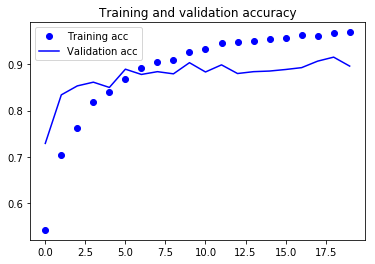

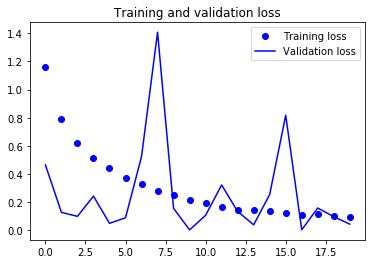

In [14]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [17]:
model.save('Jetson_nano_gpu_efficientnetB0_5_classes.h5')

In [18]:
test = './test'

In [19]:
import time

In [21]:
# 1000장 분류 시간
start = time.time()
test_generator = test_datagen.flow_from_directory(
        test,
        target_size=(224, 224),
        batch_size=20,
        class_mode='categorical')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50, workers=4, verbose=1)
print('test acc:', test_acc)
print(time.time()-start)

Found 1000 images belonging to 5 classes.
50/50 [==============================] - 71s 1s/step
test acc: 0.890999972820282
71.39175820350647


In [22]:
# 1000장 분류 시간
start = time.time()
test_generator = test_datagen.flow_from_directory(
        test,
        target_size=(224, 224),
        batch_size=20,
        class_mode='categorical')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50, workers=4, verbose=1)
print('test acc:', test_acc)
print(time.time()-start)

Found 1000 images belonging to 5 classes.
50/50 [==============================] - 70s 1s/step
test acc: 0.8930000066757202
70.57984948158264
